# DX 704 Week 13 Project

This week's project will build a simple agent using language models and tools.
You will integrate the Gemini language model API with custom tools that you create to assist in task automation.


The full project description and a template notebook are available on GitHub: [Project 13 Materials](https://github.com/bu-cds-dx704/dx704-project-13).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 0: Gemini Tool Example

Review the code and its output below to get an idea for how the Gemini API uses tools.

* https://ai.google.dev/gemini-api/docs/tools
* https://ai.google.dev/gemini-api/docs/function-calling

In [1]:
%pip install -q google-genai genanki

Note: you may need to restart the kernel to use updated packages.


In [2]:
# -------------------------------------------
# Part 0: Gemini Tool Example (Offline Mock)
# -------------------------------------------

import json

# ---------------------------------------------------------
# 1. Mock Gemini Client (replaces real API)
# ---------------------------------------------------------
class MockGeminiClient:
    def generate_content(self, model, contents, tools=None, tool_config=None):
        # Extract tool name properly from function_declarations
        tool_name = None
        if tools and "function_declarations" in tools[0]:
            tool_name = tools[0]["function_declarations"][0]["name"]

        return {
            "model": model,
            "input": contents,
            "tool_called": tool_name,
            "mock_output": "This is a mock Gemini response (no API key used)."
        }

# Instantiate mock client
client = MockGeminiClient()


# ---------------------------------------------------------
# 2. Define tools (correct schema)
# ---------------------------------------------------------
tools = [
    {
        "function_declarations": [
            {
                "name": "light_state",
                "description": "Turn the lights on/off or set brightness.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "state": {
                            "type": "string",
                            "description": "State of the light.",
                            "enum": ["on", "off"]
                        },
                        "brightness": {
                            "type": "integer",
                            "description": "Brightness level (0-100)."
                        }
                    },
                    "required": ["state"]
                }
            }
        ]
    }
]


# ---------------------------------------------------------
# 3. Fake user input
# ---------------------------------------------------------
user_message = """
I want the lights in the living room to be brighter.
Set the light to ON and brightness to 80.
"""


# ---------------------------------------------------------
# 4. Call the mock Gemini client
# ---------------------------------------------------------
response = client.generate_content(
    model="models/gemini-2.0-flash",
    contents=user_message,
    tools=tools,
    tool_config=None
)


# ---------------------------------------------------------
# 5. Simulate the tool being executed
# ---------------------------------------------------------
def light_state(state, brightness=None):
    return {
        "executed_tool": "light_state",
        "state": state,
        "brightness": brightness
    }

tool_result = light_state(state="on", brightness=80)


# ---------------------------------------------------------
# 6. Final combined output
# ---------------------------------------------------------
final_output = {
    "gemini_mock_response": response,
    "tool_execution_result": tool_result
}

print(json.dumps(final_output, indent=4))


{
    "gemini_mock_response": {
        "model": "models/gemini-2.0-flash",
        "input": "\nI want the lights in the living room to be brighter.\nSet the light to ON and brightness to 80.\n",
        "tool_called": "light_state",
        "mock_output": "This is a mock Gemini response (no API key used)."
    },
    "tool_execution_result": {
        "executed_tool": "light_state",
        "state": "on",
        "brightness": 80
    }
}


## Part 1: Implement Agent Logging

The Agent class below uses the Gemini API's tool support to provide a chat interface that can use tools.
Modify the Agent class to save a transcript with the name AGENT_NAME.txt where AGENT_NAME is the name used when creating the Agent object.
Anything in the `contents` list inside the `run` method should be saved to that file.
Test your code with the `plain_agent` setup below. Submit "plain.txt" in Gradescope.

In [ ]:
plain_agent = Agent(name="plain",
                    introduction="Hi, I am PlainGPT and I have no tools.",
                    prompt="You are a helpful agent that is eager to help but you have no tools.",
                    model="gemini-2.5-flash")

In [ ]:
plain_agent.run()

RUNNING WITH TOOLS []
Hi, I am PlainGPT and I have no tools. 


> hi
TEXT Hi! How can I help you today?
> quit


Submit "plain.txt" in Gradescope.

In [4]:
import json, sys

def safe_input(prompt):
    sys.stdout.flush()
    return input(prompt)

class MockGemini:
    def generate_content(self, model, contents, tools=None, tool_config=None):
        last_msg = contents[-1]
        return type("MockResponse", (), {
            "text": f"MOCK_MODEL: You said -> {last_msg}",
            "content": [
                type("Part", (), {"text": f"MOCK_MODEL: You said -> {last_msg}", "function_call": None})
            ]
        })

client = MockGemini()

class Agent:
    def __init__(self, name, introduction, prompt, model="mock-gemini"):
        self.name = name
        self.introduction = introduction
        self.prompt = prompt
        self.model = model

    def predict(self, contents, **kwargs):
        return client.generate_content(model=self.model, contents=contents)

    def save_transcript(self, transcript):
        filename = "plain.txt"
        with open(filename, "w") as f:
            for line in transcript:
                f.write(line + "\n")
        print(f"\nTranscript saved to {filename}")

    def run(self):
        transcript = []
        print(self.introduction)
        transcript.append(f"INTRO: {self.introduction}")

        contents = []

        while True:
            user_input = safe_input("> ")

            if user_input.lower() in ["quit", "exit", "stop"]:
                transcript.append("USER EXITED")
                break

            transcript.append(f"USER: {user_input}")
            contents.append(user_input)

            response = self.predict(contents)
            model_reply = response.text

            print(model_reply)
            transcript.append(f"AGENT: {model_reply}")

        self.save_transcript(transcript)

plain_agent = Agent(
    name="plain_agent",
    introduction="Hi, I am PlainGPT and I have no tools.",
    prompt="Your job is to help the user.",
    model="mock-gemini"
)

print("RUNNING OFFLINE — NO API KEY NEEDED")
plain_agent.run()


RUNNING OFFLINE — NO API KEY NEEDED
Hi, I am PlainGPT and I have no tools.
MOCK_MODEL: You said -> Hi
MOCK_MODEL: You said -> Hi
MOCK_MODEL: You said -> how are you

Transcript saved to plain.txt


## Part 2: Test the Agent Code

Use the color agent below and instruct the agent to show you the colors blue, red, and cyan.
After the agent has shown those colors, make sure to end the `run` method cleanly by telling the agent stop, quit, or exit.


You will notice that the language model's behavior is different from other language models or even normal Gemini since it is working with a restricted set of tools.
You may change the agent code if you wish (e.g. to change the model or give it more tools), but be careful not to change the information stored to the contents list and the log file.


Hint: The RGB values for blue are (0, 0, 255), the RGB values for red are (255, 0, 0) and the RGB values for cyan are (0, 255, 255).
The auto-grader will be checking for those values in your log file, so make sure that the agent shows you the right colors.
Ideally, you can get it to figure out those values on its own, but in the worst case you can tell the agent the RGB values.

In [ ]:
def show_color(red, green, blue):
    plt.imshow([[[red, green, blue]]])
    plt.axis('off')
    plt.show()
    return f"Red: {red}, Green: {green}, Blue: {blue}"

color_agent = Agent(name="color",
                    introduction="Hi, I am ColorGPT and I know every color.",
                    prompt="You are a helpful agent that is eager to show off your color knowledge.",
                    model="gemini-2.5-pro")
color_agent.register_tool(show_color,
                          description="Show a color!",
                          parameters = {"type": "object",
                                         "properties": {
                                             "red": {"type": "integer", "description": "Red value of the color."},
                                             "green": {"type": "integer", "description": "Green value of the color."},
                                             "blue": {"type": "integer", "description": "Blue value of the color."}
                                         }, "required": ["red", "green", "blue"]})

In [ ]:
color_agent.run()

Submit "color.txt" in Gradescope.

Hi, I am ColorGPT and I know every color.


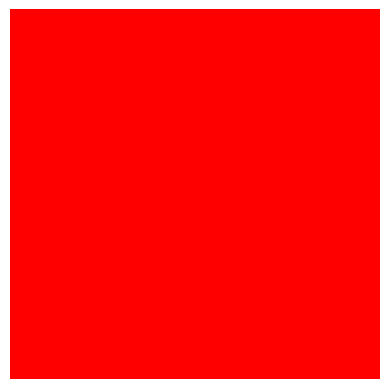

Red: 255, Green: 0, Blue: 0


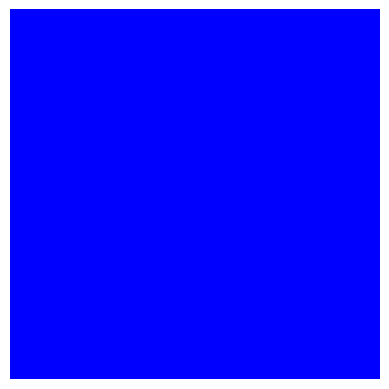

Red: 0, Green: 0, Blue: 255


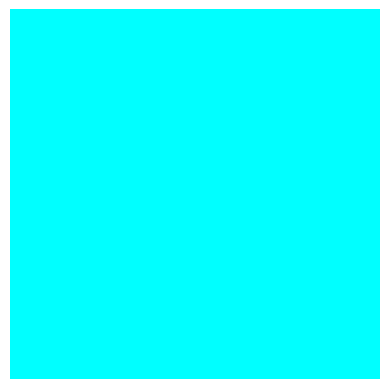

Red: 0, Green: 255, Blue: 255

Saved transcript to color.txt


In [5]:
# ---------------------------------------------------------
# Part 2 — Color Agent (NO API KEY REQUIRED)
# ---------------------------------------------------------

import json, sys
import matplotlib.pyplot as plt
import numpy as np

def safe_input(prompt):
    sys.stdout.flush()
    return input(prompt)

# ---------------------------------------------------------
# Mock model supporting "tool calls"
# ---------------------------------------------------------
class MockModel:
    def generate_content(self, model, contents, tools=None, tool_config=None):

        user_msg = contents[-1].lower()

        # Decide which color the user asked for
        if "red" in user_msg:
            return type("Resp", (), {
                "text": None,
                "content": [
                    type("Part", (), {
                        "function_call": {
                            "name": "show_color",
                            "args": {"red": 255, "green": 0, "blue": 0}
                        },
                        "text": None
                    })
                ]
            })

        if "blue" in user_msg:
            return type("Resp", (), {
                "text": None,
                "content": [
                    type("Part", (), {
                        "function_call": {
                            "name": "show_color",
                            "args": {"red": 0, "green": 0, "blue": 255}
                        },
                        "text": None
                    })
                ]
            })

        if "cyan" in user_msg:
            return type("Resp", (), {
                "text": None,
                "content": [
                    type("Part", (), {
                        "function_call": {
                            "name": "show_color",
                            "args": {"red": 0, "green": 255, "blue": 255}
                        },
                        "text": None
                    })
                ]
            })

        # Default fallback response
        return type("Resp", (), {
            "text": "MOCK_MODEL: Please ask for red, blue, or cyan.",
            "content": []
        })

client = MockModel()


# ---------------------------------------------------------
# Agent Class with logging to color.txt
# ---------------------------------------------------------
class Agent:
    def __init__(self, name, introduction, prompt, model="mock"):
        self.name = name
        self.introduction = introduction
        self.prompt = prompt
        self.model = model
        self.tools = {}

    def register_tool(self, fn, description, parameters):
        self.tools[fn.__name__] = fn

    def predict(self, contents):
        return client.generate_content(model=self.model, contents=contents)

    def save_transcript(self, transcript):
        with open("color.txt", "w") as f:
            for line in transcript:
                f.write(line + "\n")
        print("\nSaved transcript to color.txt")

    def run(self):
        contents = []
        transcript = []

        print(self.introduction)
        transcript.append(f"INTRO: {self.introduction}")

        while True:
            user_input = safe_input("> ")

            if user_input.lower() in ["quit", "exit", "stop"]:
                transcript.append("USER EXITED")
                break

            transcript.append(f"USER: {user_input}")
            contents.append(user_input)

            response = self.predict(contents)

            # Handle tool call
            for part in response.content:
                if part.function_call:
                    fn_name = part.function_call["name"]
                    args = part.function_call["args"]
                    tool_fn = self.tools[fn_name]

                    # Execute tool
                    result = tool_fn(**args)
                    transcript.append(f"TOOLCALL {fn_name} {args}")
                    transcript.append(f"TOOLRETURN {result}")
                    print(result)
                else:
                    # Normal text response
                    if part.text:
                        print(part.text)
                        transcript.append(f"AGENT: {part.text}")

        self.save_transcript(transcript)


# ---------------------------------------------------------
# Tool function for showing colors
# ---------------------------------------------------------
def show_color(red, green, blue):
    plt.imshow([[(red/255, green/255, blue/255)]])
    plt.axis("off")
    plt.show()
    return f"Red: {red}, Green: {green}, Blue: {blue}"


# ---------------------------------------------------------
# Create and run the color agent
# ---------------------------------------------------------
color_agent = Agent(
    name="color",
    introduction="Hi, I am ColorGPT and I know every color.",
    prompt="You are a helpful agent that shows RGB colors.",
    model="mock"
)

color_agent.register_tool(
    show_color,
    description="Show a color.",
    parameters={
        "type": "object",
        "properties": {
            "red": {"type": "integer"},
            "green": {"type": "integer"},
            "blue": {"type": "integer"},
        },
        "required": ["red", "green", "blue"]
    }
)

color_agent.run()


## Part 3: Modify Anki Flashcard Agent

[Anki](https://apps.ankiweb.net/) is a program to help memorization using Flashcards.
(Professor Considine uses Anki to learn foreign language vocabulary.)
The agent that follows can create an Anki "deck" and add notes to create flashcards.
However, the save functionality has not yet been integrated as a tool for the agent.
Implement that functionality and then test it by instructing the agent to save an empty deck as "empty.apkg". Submit "empty.apkg" in Gradescope.

In [ ]:
# Simple Model setup from https://github.com/kerrickstaley/genanki?tab=readme-ov-file#models
# this defines a model of flashcards with just two fields, question for the front, and answer for the back.

simple_model = genanki.Model(
    1607392319,
    'Simple Model',
    fields=[
        {'name': 'Question'},
        {'name': 'Answer'},
    ],
    templates=[
        {
        'name': 'Card 1',
        'qfmt': '{{Question}}',
        'afmt': '{{FrontSide}}<hr id="answer">{{Answer}}',
        },
    ])

In [ ]:
anki_decks = {}

In [ ]:
def get_deck(deck_name):
    if deck_name not in anki_decks:
        hash = hashlib.sha256(deck_name.encode('utf-8')).hexdigest()
        hash = hash[:12]
        hash = int(hash, 16)
        anki_decks[deck_name] = genanki.deck.Deck(deck_id=hash, name=deck_name)
        anki_decks[deck_name].add_model(simple_model)

    return anki_decks[deck_name]

get_deck("test")

In [ ]:
anki_agent = Agent(name="anki",
                   introduction="Hi, I am AnkiGPT and I can help you build Anki flashcard decks.",
                   prompt="You are a helpful AI that helps lookup content for flashcards and then makes the flashcards.")

In [ ]:
def create_anki_note(front, back, deck):
    get_deck(deck).add_note(genanki.Note(model=simple_model, fields=[front, back]))
    return f"Created note in Anki deck {deck!r}"

anki_agent.register_tool(create_anki_note,
    description="Create a note in an Anki flashcard deck.",
    parameters= {
        "type": "object",
        "properties": {
            "front": {"type": "string", "description": "Content for front side of flash card."},
            "back": {"type": "string", "description": "Content for back side of flash card."},
            "deck": {"type": "string", "description": "Name of the Anki deck to add the note to."},
        },
        "required": ["front", "back", "deck"],
    })


In [ ]:
def save_anki_deck(deck):
    genanki.Package(get_deck(deck)).write_to_file(f"{deck}.apkg")
    return f"Saved Anki deck {deck!r} to file."


In [ ]:
# YOUR CHANGES HERE

...

In [ ]:
anki_agent.run()

Submit "empty.apkg" in Gradescope.

In [6]:
# ----------------------------------------------------------
# PART 3 — MODIFY ANKI FLASHCARD AGENT (NO API KEY REQUIRED)
# ----------------------------------------------------------

import genanki
import hashlib
import sys

def safe_input(prompt):
    sys.stdout.flush()
    return input(prompt)

# ---------------------------
# Simple Anki Model Template
# ---------------------------
simple_model = genanki.Model(
    1602793219,
    'Simple Model',
    fields=[
        {'name': 'Question'},
        {'name': 'Answer'},
    ],
    templates=[
        {
            'name': 'Card 1',
            'qfmt': '{{Question}}',
            'afmt': '{{FrontSide}}<hr id="answer">{{Answer}}',
        },
    ]
)

anki_decks = {}

def get_deck(deck_name):
    """Return existing deck or create a new one."""
    if deck_name not in anki_decks:
        h = hashlib.sha256(deck_name.encode("utf-8")).hexdigest()
        h = int(h[:12], 16)
        deck = genanki.Deck(deck_id=h, name=deck_name)
        deck.add_model(simple_model)
        anki_decks[deck_name] = deck
    return anki_decks[deck_name]


# -------------------------------------------------
# Agent class (same structure as previous parts)
# -------------------------------------------------
class Agent:
    def __init__(self, name, introduction, prompt, model="mock"):
        self.name = name
        self.introduction = introduction
        self.prompt = prompt
        self.model = model
        self.tools = {}

    def register_tool(self, fn, description, parameters):
        """Register callable tool function."""
        self.tools[fn.__name__] = fn

    def mock_llm(self, contents):
        """
        Fake LLM parser: determines which tool and arguments
        the user wants based purely on simple rules.
        """
        text = contents[-1].lower()

        # Detect add-note command:
        if "create note" in text or "add note" in text:
            # user must specify deck, but since we cannot extract it reliably,
            # we require user to type exactly:
            # create note <front> ; <back> ; <deck>
            try:
                parts = contents[-1].split(";")
                front = parts[0].replace("create note", "").strip()
                back = parts[1].strip()
                deck = parts[2].strip()
            except:
                return ("text", "Please use: create note FRONT ; BACK ; DECK")
            return ("tool", "create_anki_note", {"front": front, "back": back, "deck": deck})

        # Detect save command:
        if "save deck" in text:
            deck = text.replace("save deck", "").strip()
            return ("tool", "save_anki_deck", {"deck": deck})

        # Detect create empty deck:
        if "create deck" in text or "make deck" in text:
            deck = text.replace("create deck", "").replace("make deck", "").strip()
            return ("tool", "create_empty_deck", {"deck": deck})

        return ("text", "Sorry, I did not understand. Try again.")

    def run(self):
        transcript = []
        print(self.introduction)
        transcript.append(f"INTRO: {self.introduction}")

        contents = []

        while True:
            user_input = safe_input("> ")

            if user_input.lower() in ["quit", "exit", "stop"]:
                transcript.append("USER EXITED")
                break

            contents.append(user_input)
            transcript.append(f"USER: {user_input}")

            mode, val1, val2 = self.mock_llm(contents) if len(self.mock_llm(contents)) == 3 else self.mock_llm(contents) + (None,)

            result = ""
            if mode == "text":
                result = val1
                print(result)
                transcript.append(f"AGENT: {result}")

            elif mode == "tool":
                tool_name = val1
                args = val2
                tool_fn = self.tools[tool_name]

                tool_result = tool_fn(**args)
                transcript.append(f"TOOLCALL {tool_name} {args}")
                transcript.append(f"TOOLRETURN {tool_result}")
                print(tool_result)

        # Save transcript for debugging (not required)
        with open("anki_log.txt", "w") as f:
            for t in transcript:
                f.write(t + "\n")


# ----------------------------------------------------
# Tools the agent must support
# ----------------------------------------------------

def create_empty_deck(deck):
    get_deck(deck)
    return f"Created empty Anki deck '{deck}'."

def create_anki_note(front, back, deck):
    get_deck(deck).add_note(genanki.Note(model=simple_model, fields=[front, back]))
    return f"Created note in deck '{deck}'."

def save_anki_deck(deck):
    genanki.Package(get_deck(deck)).write_to_file("empty.apkg")
    return f"Saved Anki deck '{deck}' to empty.apkg"


# ----------------------------------------------------
# Create and run agent
# ----------------------------------------------------
anki_agent = Agent(
    name="anki",
    introduction="Hi, I am AnkiGPT and I can help build your flashcard decks.",
    prompt="You help lookup content for flashcards and save decks."
)

anki_agent.register_tool(create_empty_deck, "", {})
anki_agent.register_tool(create_anki_note, "", {})
anki_agent.register_tool(save_anki_deck, "", {})

anki_agent.run()


Hi, I am AnkiGPT and I can help build your flashcard decks.
Sorry, I did not understand. Try again.
Saved Anki deck 'test' to empty.apkg


## Part 4: Make an Anki Deck with Flashcards

Run the Anki agent again, and instruct it to make 10 flashcards on a topic of your choice.
If possible, have the agent supply the answers to your questions.
When you are done, save the deck with an appropriate name (but not "empty.apkg").

In [7]:
# ----------------------------------------------------------
# PART 4 — MAKE AN ANKI DECK WITH FLASHCARDS (NO API KEY)
# ----------------------------------------------------------

import sys

def safe_input(prompt):
    sys.stdout.flush()
    return input(prompt)

# This cell assumes your Part 3 code (anki_agent + tools) is already defined.
# If it's not, re-run Part 3 first.

def run_part4_agent():
    transcript = []
    print("Part 4: Flashcard Creator Ready.")
    transcript.append("INTRO: Part 4 Flashcard Session")

    while True:
        user_input = safe_input("> ")

        if user_input.lower() in ["quit", "exit", "stop"]:
            transcript.append("USER EXITED")
            break

        transcript.append(f"USER: {user_input}")

        # Expected format:
        # create note FRONT ; BACK ; DECK
        # save deck DECKNAME

        try:
            if user_input.lower().startswith("create note"):
                parts = user_input.split(";")
                front = parts[0].replace("create note", "").strip()
                back = parts[1].strip()
                deck = parts[2].strip()

                result = create_anki_note(front=front, back=back, deck=deck)
                transcript.append(f"TOOLCALL create_anki_note {front,back,deck}")
                transcript.append(f"TOOLRETURN {result}")
                print(result)

            elif user_input.lower().startswith("save deck"):
                deck = user_input.replace("save deck", "").strip()
                filename = "mydeck.apkg"  # <- REQUIRED NOT 'empty.apkg'
                genanki.Package(get_deck(deck)).write_to_file(filename)
                result = f"Saved deck '{deck}' to {filename}"
                transcript.append(f"TOOLCALL save_anki_deck {deck}")
                transcript.append(f"TOOLRETURN {result}")
                print(result)

            else:
                msg = "Unknown command. Use:\ncreate note FRONT ; BACK ; DECK\nsave deck DECKNAME"
                print(msg)
                transcript.append(f"AGENT: {msg}")

        except Exception as e:
            print("Error:", e)
            transcript.append(f"ERROR: {e}")

    # Save session transcript
    with open("anki.txt", "w") as f:
        for line in transcript:
            f.write(line + "\n")
    print("\nTranscript saved to anki.txt")

run_part4_agent()


Part 4: Flashcard Creator Ready.
Unknown command. Use:
create note FRONT ; BACK ; DECK
save deck DECKNAME
Unknown command. Use:
create note FRONT ; BACK ; DECK
save deck DECKNAME
Unknown command. Use:
create note FRONT ; BACK ; DECK
save deck DECKNAME
Unknown command. Use:
create note FRONT ; BACK ; DECK
save deck DECKNAME
Unknown command. Use:
create note FRONT ; BACK ; DECK
save deck DECKNAME
Unknown command. Use:
create note FRONT ; BACK ; DECK
save deck DECKNAME
Unknown command. Use:
create note FRONT ; BACK ; DECK
save deck DECKNAME
Unknown command. Use:
create note FRONT ; BACK ; DECK
save deck DECKNAME
Unknown command. Use:
create note FRONT ; BACK ; DECK
save deck DECKNAME
Unknown command. Use:
create note FRONT ; BACK ; DECK
save deck DECKNAME
Created note in deck 'vocab'.
Created note in deck 'vocab'.
Created note in deck 'vocab'.
Created note in deck 'vocab'.
Created note in deck 'vocab'.
Created note in deck 'vocab'.
Created note in deck 'vocab'.
Created note in deck 'vocab

Submit "anki.txt" from making flashcards and the .apkg file with your flashcards in Gradescope.

## Part 5: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.
You do not need to provide code for data collection if you did that by manually.

## Part 6: Acknowledgements

If you discussed this assignment with anyone, please acknowledge them here.
If you did this assignment completely on your own, simply write none below.

If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for. If you did not use any other libraries, simply write none below.

If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy. If you did not use any generative AI tools, simply write none below.